## Tema: Queimadas e Incêndios Florestais no Brasil
PUC Minas: TCC - Ciência de Dados e Big Data <br>
Aluna: Monique Ellen da Silva Acacio


### Origem dos dados

Dados exportados do sistema de monitoramento DBQueimadas, disponível través do link http://queimadas.dgi.inpe.br/queimadas/portal. Maiores informações para coleta de dados estão disponíveis na documentação deste projeto.

Devido a limitação de período durante a exportação dos dados, foram gerados 15 arquivos CSVs que em conjunto compõe o dataset utilizado neste projeto. Cada arquivo contém dados de um ano completo, de 2005 até 2019, sendo cada linha no dataset a representação de um foco de queimada.

### Processamento / Tratamento dos dados

In [1]:
#Bibliotecas básicas
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pylab as p 
import math

#Bibliotecas para estatisticas
import descartes
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Biblioteca para tratamento de warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#Definição do padrão visual de todos os gráficos
sns.set_style('whitegrid')

Optei por concatenar todos os arquivos em um único DataFrame durante o processo de importação.

In [2]:
#Importação dos arquivos concatenando em um único data frame

path = 'Dados/' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

focos_df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
#Visualização dos três primeiros registros do DataFrame criado
focos_df.head(3)

,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2017/01/05 16:18:00,AQUA_M-T,Brasil,MINAS GERAIS,OURO PRETO,Mata Atlantica,0.0,0.9,0.7,-20.608,-43.510,NaN
1,2017/01/08 16:45:00,AQUA_M-T,Brasil,RIO GRANDE DO SUL,SANTA VITORIA DO PALMAR,Pampa,0.0,3.5,-999.0,-33.317,-52.848,NaN
2,2017/01/08 16:48:00,AQUA_M-T,Brasil,PARANA,CAMPO MOURAO,Mata Atlantica,0.0,2.8,-999.0,-24.049,-52.395,NaN


Verificação do total de registros e tipo das colunas.

In [4]:
focos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310492 entries, 0 to 3310491
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   datahora      object 
 1   satelite      object 
 2   pais          object 
 3   estado        object 
 4   municipio     object 
 5   bioma         object 
 6   diasemchuva   float64
 7   precipitacao  float64
 8   riscofogo     float64
 9   latitude      float64
 10  longitude     float64
 11  frp           float64
dtypes: float64(6), object(6)
memory usage: 303.1+ MB


Verificação dos valores duplicados ou incorretos.

In [5]:
print('Pais: ', focos_df.pais.unique(), '\n')
print('Satelite: ', focos_df.satelite.unique(), '\n')
print('Estados: ', focos_df.estado.unique(), '\n')
print('Bioma: ', focos_df.bioma.unique(), '\n')

Pais:  ['Brasil'] 

Satelite:  ['AQUA_M-T'] 

Estados:  ['MINAS GERAIS' 'RIO GRANDE DO SUL' 'PARANA' 'SAO PAULO' 'PIAUI'
 'MARANHAO' 'CEARA' 'MATO GROSSO' 'SERGIPE' 'GOIAS' 'RIO GRANDE DO NORTE'
 'PARA' 'AMAZONAS' 'BAHIA' 'MATO GROSSO DO SUL' 'PERNAMBUCO' 'TOCANTINS'
 'SANTA CATARINA' 'PARAIBA' 'ALAGOAS' 'RORAIMA' 'RONDONIA'
 'ESPIRITO SANTO' 'AMAPA' 'RIO DE JANEIRO' 'DISTRITO FEDERAL' 'ACRE'] 

Bioma:  ['Mata Atlantica' 'Pampa' 'Caatinga' 'Cerrado' 'Amazonia' 'Pantanal' nan] 



Optei por remover as colunas que não tem relevância para no problema proposto.

Coluna | Motivo do descarte
-------| ------------------
pais   | neste dataset apenas o Brasil é representado
satelite |neste dataset todos os dados foram coletados do mesmo satélite conforme orientação duante a coletado de dados logo não é necessário manter esta coluna
diasemchuva | nas análises realizadas será considerado apenas a frequencia dos focos, neste caso os dias sem chuva não serão relevantes
precipitacao | nas análises realizadas será considerado apenas a frequencia dos focos, neste caso o valor da preciptação aculada até o momento da detecção do fogo não é relevante
riscofogo | nas análises realizadas será considerado apenas a frequencia dos focos, o valor de risco de fogo é calculado pelo INEP e não é relevante no contexto desta análise
frp | nas análises realizadas será considerado apenas a frequencia dos focos, o Fire Radioative Power não é relevante no contexto desta análise

In [6]:
#Remoção das colunas
focos_df=focos_df.drop(columns=['pais','satelite','diasemchuva', 'precipitacao', 'riscofogo','frp'])
focos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310492 entries, 0 to 3310491
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   datahora   object 
 1   estado     object 
 2   municipio  object 
 3   bioma      object 
 4   latitude   float64
 5   longitude  float64
dtypes: float64(2), object(4)
memory usage: 151.5+ MB


Ajuste do dtype da coluna datahora para datetime.

In [7]:
#Alterando o dtype
focos_df['datahora'] = pd.to_datetime(focos_df['datahora'], format='%Y/%m/%d %H:%M:%S')
focos_df.dtypes

datahora     datetime64[ns]
estado               object
municipio            object
bioma                object
latitude            float64
longitude           float64
dtype: object

Como o objetivo é análisar a frequência da ocorrência dos focos de queimada, optei por adicionar duas colunas sendo uma para registro do ano e outro do mês da ocorrência.

In [8]:
#Criando as colunas ano e mes
focos_df['ano']=pd.DatetimeIndex(focos_df['datahora']).year
focos_df['mes']=pd.DatetimeIndex(focos_df['datahora']).month_name()

#Ajustando os meses para português
mes={'January': 'Janeiro', 'February': 'Fevereiro', 'March': 'Março', 'April': 'Abril', 'May': 'Maio',
          'June': 'Junho', 'July': 'Julho', 'August': 'Agosto', 'September': 'Setembro', 'October': 'Outubro',
          'November': 'Novembro', 'December': 'Dezembro'}
focos_df['mes']=focos_df['mes'].map(mes)
#Verificando o ajuste
focos_df.mes.unique()

array(['Janeiro', 'Fevereiro', 'Abril', 'Maio', 'Junho', 'Julho',
       'Agosto', 'Setembro', 'Novembro', 'Dezembro', 'Março', 'Outubro'],
      dtype=object)

In [9]:
#Verificação do dataFrame
focos_df.head(5)

,datahora,estado,municipio,bioma,latitude,longitude,ano,mes
0,2017-01-05 16:18:00,MINAS GERAIS,OURO PRETO,Mata Atlantica,-20.608,-43.510,2017,Janeiro
1,2017-01-08 16:45:00,RIO GRANDE DO SUL,SANTA VITORIA DO PALMAR,Pampa,-33.317,-52.848,2017,Janeiro
2,2017-01-08 16:48:00,PARANA,CAMPO MOURAO,Mata Atlantica,-24.049,-52.395,2017,Janeiro
3,2017-01-08 16:48:00,SAO PAULO,SAO SEBASTIAO,Mata Atlantica,-23.764,-45.414,2017,Janeiro
4,2017-01-12 16:29:00,PIAUI,CARAUBAS DO PIAUI,Caatinga,-3.473,-41.709,2017,Janeiro


Verificação de valores nulos:

In [10]:
#Verificação do total de valores nulos em cada  coluna
focos_df.isna().sum()

datahora     0
estado       0
municipio    0
bioma        1
latitude     0
longitude    0
ano          0
mes          0
dtype: int64

Como o dataset apresenta apenas um único registro com dado nulo, o registro será removido sem maiores danos.

In [11]:
#Remoção do registro que possui o bioma nulo
focos_df=focos_df.dropna()

#Verificação dos valores nulos
focos_df.isna().sum()

datahora     0
estado       0
municipio    0
bioma        0
latitude     0
longitude    0
ano          0
mes          0
dtype: int64

Verificação do dataset final:

In [12]:
focos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3310491 entries, 0 to 3310491
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datahora   datetime64[ns]
 1   estado     object        
 2   municipio  object        
 3   bioma      object        
 4   latitude   float64       
 5   longitude  float64       
 6   ano        int64         
 7   mes        object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 227.3+ MB


### Análise e Exploração dos Dados

Para apoiar a contextualização das análises o mapa abaixo é uma referência para localização dos biomas e estados brasileiros.

![Mapa do brasil subdividido por bioma](mapa.png)


#### <span style="color:blue">Qual o total de focos de queimada ao longo dos últimos 15 anos?</span>

Para esta verificação os dados foram agrupados por ano, contabilizando o total de registros de cada ano. Como forma de verificação de tendência foi calculado a média móvel ao longo da série.

     ano   total
0   2005  362566
1   2006  249184
2   2007  393914
3   2008  211933
4   2009  155104
5   2010  319386
6   2011  158102
7   2012  217238
8   2013  128149
9   2014  175900
10  2015  216782
11  2016  184218
12  2017  207511
13  2018  132872
14  2019  197632


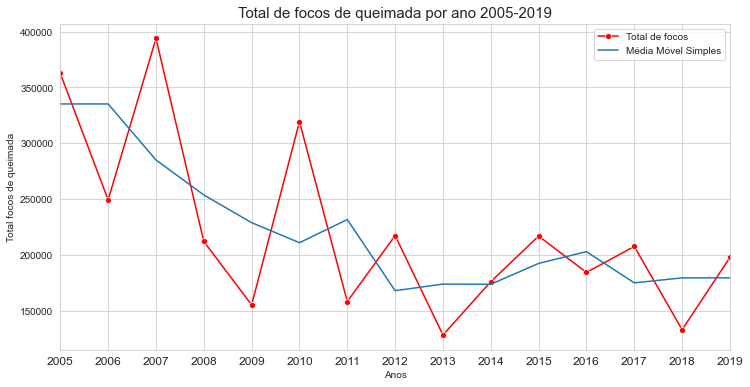

In [13]:
#Preparação dos dados
focos_ano=pd.DataFrame(focos_df.groupby(['ano'])['mes'].count()).reset_index()
focos_ano.rename(columns={'mes': 'total'}, inplace = True)
print(focos_ano)

#Calculo da média móvel simples de queimadas ao longo dos anos
ano=focos_ano.set_index('ano')
inicio = 2006
fim = 2019
mms = []

i = inicio
while i < fim:
    y=i
    w=i
    y -=1
    w +=1
    ano_anterior = ano.total.loc[y]
    ano_atual = ano.total.loc[i]
    ano_proximo = ano.total.loc[w]
    media = (ano_anterior + ano_atual + ano_proximo) / 3
    
    mms.append(media)
    i += 1


#Não é possível calcular a MMS para os anos extremos, 2005 e 2019. Sendo assim, foram adicionados os dados mais próximos.
mms.insert(0, mms[0]) 
mms.append(mms[-1])
mms = pd.Series(mms) 

#Criando o gráfico
plt.figure(figsize=(12,6))
sns.lineplot(x='ano', y='total', data=focos_ano, marker='o', linestyle='-', color='red',label='Total de focos' )
sns.lineplot(x='ano', y=mms, data=focos_ano, label='Média Móvel Simples')
plt.ylabel('Total focos de queimada')
plt.xlabel('Anos')
plt.xlim(2005,2019)
plt.xticks(np.arange(2005, 2020, 1),fontsize=12)
plt.title('Total de focos de queimada por ano 2005-2019', fontsize=15)
plt.grid(True)

plt.legend()
plt.show()

No geral, até 2019, a quantidade de incêndios florestais desde 2005 diminuiu ao longo dos anos. Houve um período crítico entre 2005 e 2010, com grande quantidade de focos de queimada, em especial em 2007 com o total de 207511.

#### <span style="color:blue">Quais são os meses com maior incência de focos de incêndio?</span>

Para esta verificação os dados foram agrupados por mês, contabilizando o total de registros independete do ano. 

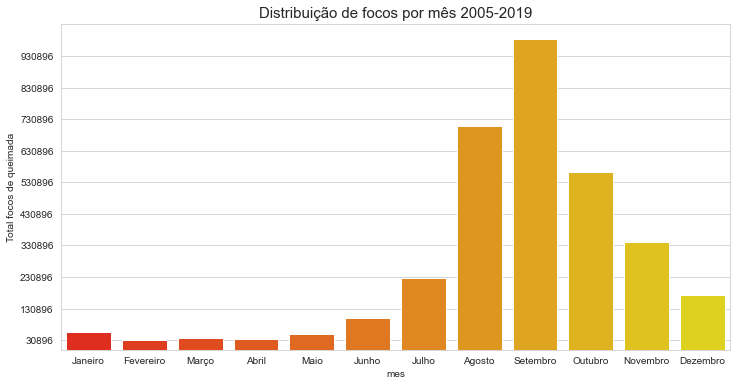

In [14]:
#Preparação dos dados
ordem=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']
focos_mes=pd.DataFrame(focos_df.groupby('mes')['ano'].count()).reset_index()
focos_mes.rename(columns={'ano': 'total'}, inplace = True)
focos_mes['mes']=pd.Categorical(focos_mes['mes'], categories=ordem, ordered=True)
focos_mes.sort_values('mes', inplace=True)


#Criando o gráfico
plt.figure(figsize=(12,6))
plt.yticks(np.arange(focos_mes.total.min(), focos_mes.total.max(), 100000))
sns.barplot(data=focos_mes, x='mes', y='total', palette='autumn')
plt.title('Distribuição de focos por mês 2005-2019', fontsize=15)
plt.ylabel('Total focos de queimada')
plt.axis(True)
plt.show()

É possível observar que o segundo semestre apresenta um aumento no número de focos em relação ao primeiro semeste. Contudo, este aumento é esperado considerando o período de seca na maior parte dos biomas.
De maneira geral, os meses de agosto, setembro e outubro merecem mais atenção na prevenção de incêndios florestais.


##### <span style="color:blue">Quais são os 10 estado mais afetados?</span>

Para esta verificação os dados foram agrupados por estado, contabilizando o total de registros independente do ano. Ao final foram selecionados os 10 estados com maior número de focos de queimada.

          estado   total
13          PARA  641376
10   MATO GROSSO  523062
9       MARANHAO  383247
26     TOCANTINS  219404
21      RONDONIA  212506
4          BAHIA  190987
17         PIAUI  161626
3       AMAZONAS  156815
12  MINAS GERAIS  153217
0           ACRE   99086


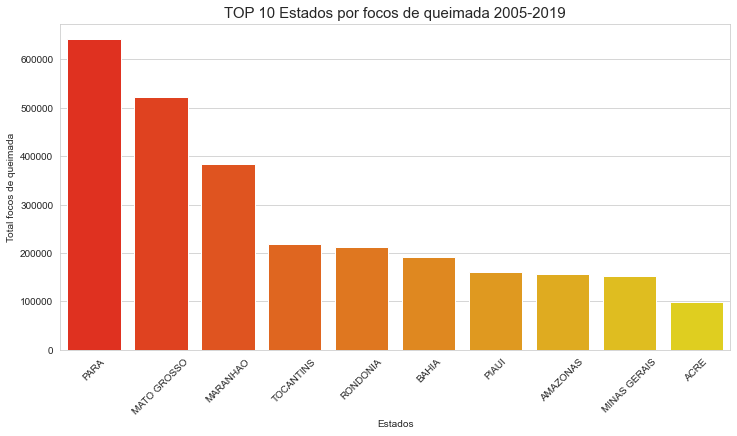

In [15]:
#Preparação dos dados
focos_estado=pd.DataFrame(focos_df.groupby(['estado'])['mes'].count()).reset_index()
focos_estado.rename(columns={'mes': 'total'}, inplace = True)
focos_estado=focos_estado.nlargest(10, columns='total')
print(focos_estado)

#Criando o gráfico
plt.figure(figsize=(12,6))

sns.barplot(data=focos_estado, x='estado', y='total', palette='autumn')
plt.xticks(rotation=45)
plt.ylabel('Total focos de queimada')
plt.xlabel('Estados')
plt.title('TOP 10 Estados por focos de queimada 2005-2019', fontsize=15)
plt.show()

O Pará, Mato Grosso e Maranhã lideram como os Estados com maior número de queimadas.

##### <span style="color:blue">Focos de queimada por bioma ao longo dos anos?</span>


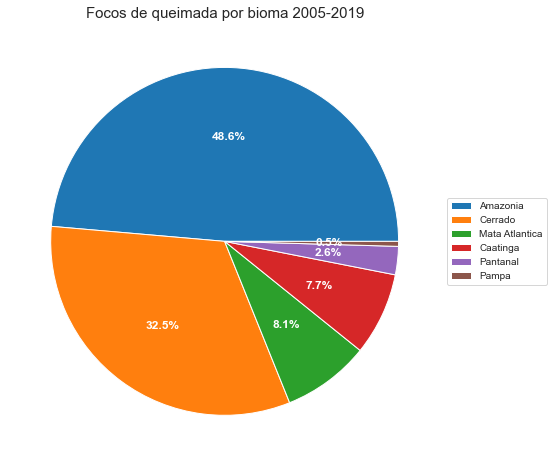

In [16]:
#Preparação dos dados
focos_bioma=pd.DataFrame(focos_df.groupby(['bioma'])['mes'].count()).reset_index()
focos_bioma.rename(columns={'mes': 'total'}, inplace = True)
focos_bioma=focos_bioma.sort_values('total', ascending=False)

#Criando o gráfico
plt.figure(figsize=(12,8))
plt.pie(focos_bioma['total'], autopct='%1.1f%%', textprops=dict(color="w", weight="bold", size=12))
plt.xticks(rotation=45)
plt.title('Focos de queimada por bioma 2005-2019', fontsize=15)
plt.legend(focos_bioma['bioma'],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Praticamente metade dos focos de queimada que ocorreram de 2005 até 20019 foram na Amazonia, o que corresponde com o alto número de queimadas nos estados do Pará e do Mato Grosso. 

##### <span style="color:blue">Mapas de calor (Heatmap)</span>


Para melhor visualização dos padrões optei por criar algumas mapas de calor (Heatmap) correlacionando frequencia e localização dos focos de queimada.

**Total de focos por mês ao longo dos anos**

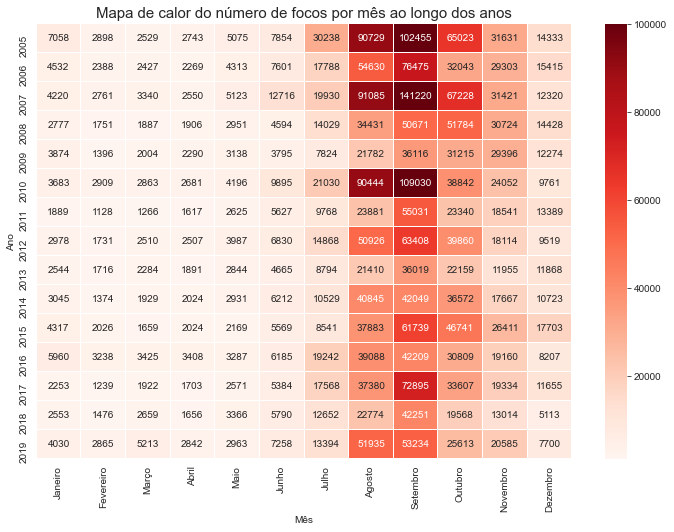

In [17]:
#Preparando os dados
mes_ano=focos_df.groupby(['ano','mes']).count()['estado'].reset_index().rename(columns={'estado': 'total'})
pivot = mes_ano.pivot_table(values='total', index='ano', columns='mes', aggfunc=np.sum)
pivot = pivot.loc[:,['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto','Setembro', 'Outubro', 'Novembro', 'Dezembro']]

#Criando o gráfico
plt.figure(figsize=(12,8))
sns.heatmap(pivot, linewidths=0.05, vmax=100000, cmap='Reds', fmt="1.0f", annot=True)
plt.title('Mapa de calor do número de focos por mês ao longo dos anos', fontsize=15)
plt.xlabel('Mês')
plt.ylabel('Ano')
plt.show()

Obervando os meses ao longo dos anos, os meses de Agosto e Semtembro como os mais críticos com um total de focos de queimada bem elevado em comparação com os demais meses.

**Total de focos por estado ao longo dos meses**

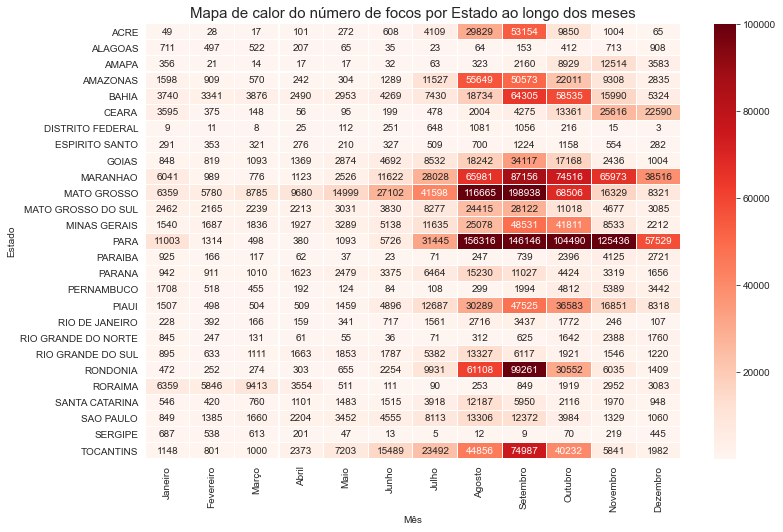

In [18]:
#Preparando os dados 
mes_estado=focos_df.groupby(['mes','estado']).count()['ano'].reset_index().rename(columns={'ano': 'total'})
pivot2= mes_estado.pivot_table(values='total', index='estado', columns='mes', aggfunc=np.sum)
pivot2=pivot2.loc[:,['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto','Setembro', 'Outubro', 'Novembro', 'Dezembro']]


#Criando o gráfico
plt.figure(figsize=(12,8))

sns.heatmap(pivot2, linewidths=0.05, vmax=100000, cmap='Reds', fmt="1.0f", annot=True)
plt.title('Mapa de calor do número de focos por Estado ao longo dos meses', fontsize=15)
plt.xlabel('Mês')
plt.ylabel('Estado')
plt.show()

Observando o total de queimadas por estado ao longo dos meses é possível verificar que o estado do Pará e Maranhão apresenta um período crítico de queimadas maior que os outros estados, estendendo o alto número de queimadas até o mês de dezembro.

**Total de focos por bioma ao longo dos meses**

<function matplotlib.pyplot.show(close=None, block=None)>

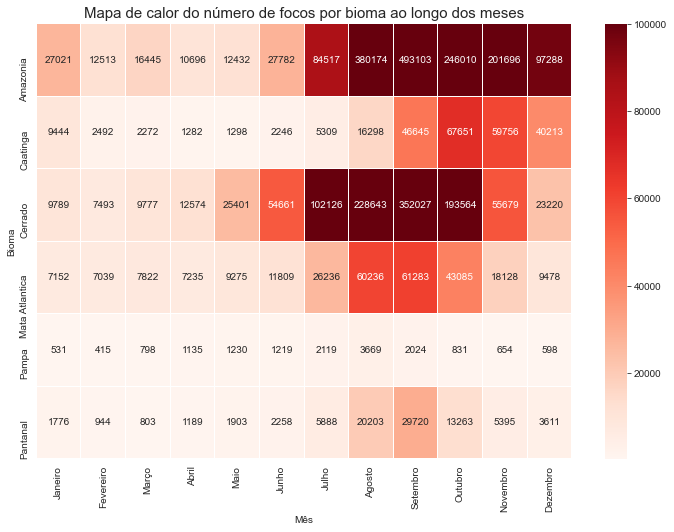

In [19]:
#Preparação dos dados
mes_bioma=focos_df.groupby(['mes','bioma']).count()['ano'].reset_index().rename(columns={'ano': 'total'})
pivot3= mes_bioma.pivot_table(values='total', index='bioma', columns='mes', aggfunc=np.sum)
pivot3=pivot3.loc[:,['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto','Setembro', 'Outubro', 'Novembro', 'Dezembro']]

#Criando o gráfico
plt.figure(figsize=(12,8))
sns.heatmap(pivot3, linewidths=0.05, vmax=100000, cmap='Reds', fmt="1.0f", annot=True)
plt.title('Mapa de calor do número de focos por bioma ao longo dos meses', fontsize=15)
plt.xlabel('Mês')
plt.ylabel('Bioma')
plt.show

Na visualização do total de queimadas por bioma ao longo dos meses fica ainda mais evidênte o alto número de queimadas na Amazonia e no Cerrado.

### Predição - Modelo ARIMA

Para a serie apresentada optei por aplicar o modelo de predição ARIMA por ser o modelo apresentado no curso para séries temporais.

Para criação do modelo foi considerada a série com o somatório mesal de focos de queimadas ao longo dos anos, conforme representação gráfica abaixo.



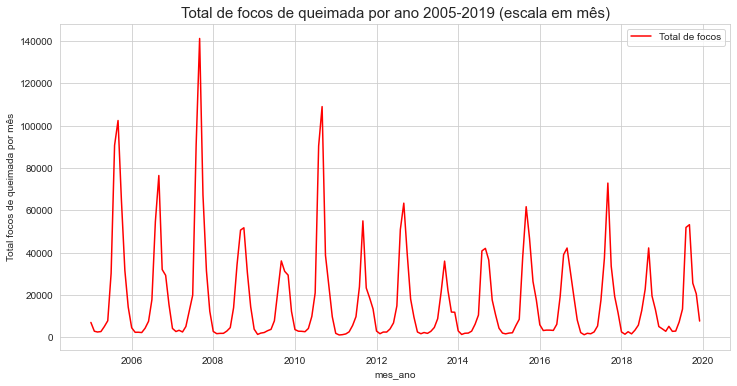

In [20]:
#Coletando dados por dia e criando a série original do modelo
serie_ori=focos_df
serie_ori['mes_ano']=focos_df.datahora.astype('datetime64[M]')
serie_ori=serie_ori.groupby('mes_ano')['datahora'].count().reset_index().rename(columns={'datahora': 'total'})

#Criando o gráfico
plt.figure(figsize=(12,6))
sns.lineplot(x='mes_ano', y='total', data=serie_ori, color='red',label='Total de focos' )
plt.ylabel('Total focos de queimada por mês')
plt.title('Total de focos de queimada por ano 2005-2019 (escala em mês)', fontsize=15)
plt.grid(True)

plt.legend()
plt.show()

**Dividindo o dataset**

Optei por dividir o conjunto de dados em duas partes, uma com dados referentes a 13 anos (2005-2017) e outra com  dados referentes a 2 anos(2018-2019). A primeira parte é o conjunto de dados de treinamento que usaremos para preparar um modelo ARIMA. A segunda parte é o conjunto de dados de teste que fingiremos não estar disponível, são essas etapas de tempo que trataremos como fora da amostra.


In [21]:
# dividindo o dataset
div=len(serie_ori) - 24 #24 meses = 2 anos
serie_treino, serie_teste = serie_ori[0:div], serie_ori[div:]
print('Serie Treino %d, Serie Teste %d' % (len(serie_treino), len(serie_teste)))
serie_treino.set_index('mes_ano', inplace=True)
serie_teste.set_index('mes_ano', inplace=True)
serie_treino.head()

Serie Treino 156, Serie Teste 24


,total
mes_ano,
2005-01-01,7058
2005-02-01,2898
2005-03-01,2529
2005-04-01,2743
2005-05-01,5075


 **Decomposição da série**

A decomposição é usada principalmente para análise de séries temporais e, como uma ferramenta de análise, pode ser usada para informar os modelos de previsão sobre o seu problema.


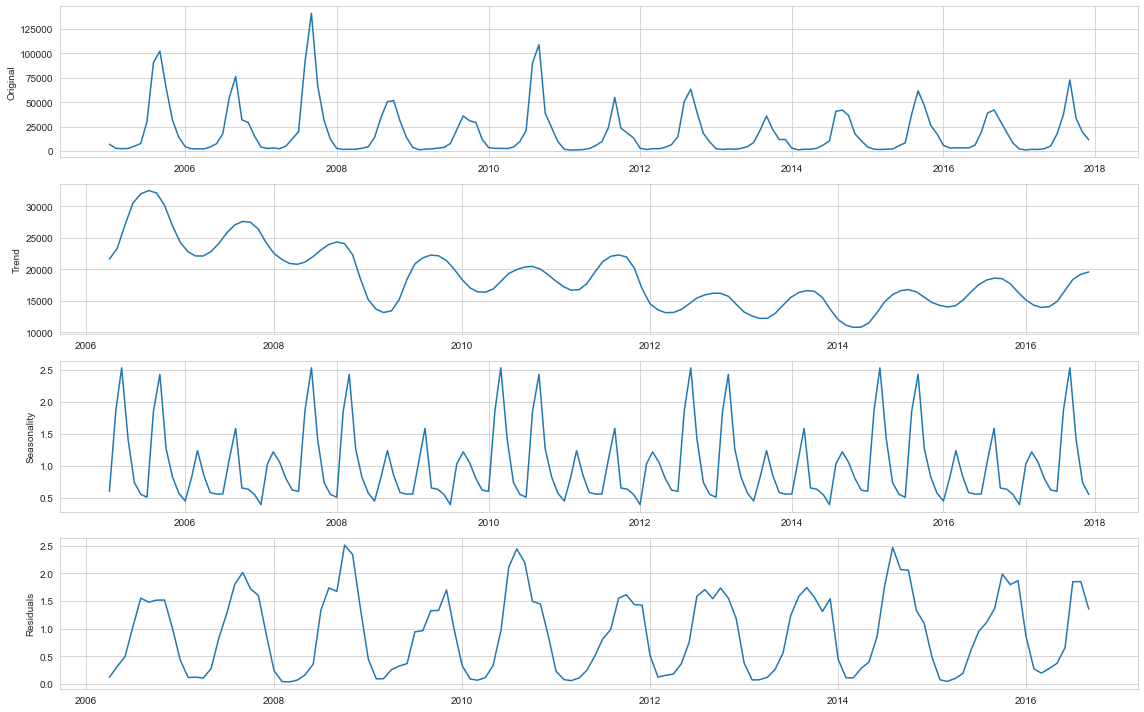

In [22]:
#Decomposição da série temporal
decompose=seasonal_decompose(serie_treino, model='multiplicative', period=30)
trend=decompose.trend
seasonal=decompose.seasonal
resid=decompose.resid

plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(serie_treino)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(resid)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

Podemos ver que as informações de tendência e sazonalidade extraídas da série parecem razoáveis, confirmando as observações realizadas durante a análise dos dados.

Para dar continuidade a análise será verificado se a série é estacionária.


 **Estacionariedade**
 
 
O teste ADF é um tipo de teste estatístico denominado teste de raiz unitária. A intuição por trás de um teste de raiz unitária é que ele determina a intensidade com que uma série temporal é definida por uma tendência.
Interpretamos esse resultado usando o valor p do teste. Um valor de p abaixo de um limite (como 5% ou 1%) sugere que rejeitamos a hipótese nula (estacionário), caso contrário, um valor de p acima do limite sugere que falhamos em rejeitar a hipótese nula (não estacionário).

In [23]:
#Verificando se a série é estacionária.
def estacionaria(y):
    print('Resultado do Teste Dickey-Fuller:')
    teste = adfuller(y, autolag="AIC")
    saida = pd.Series(teste[0:4], index=['Teste','Valor p', 'Nº de lags', 'Nº de observações'])
    for key, value in teste[4].items():
        saida['Valor Crítico ({})'.format(key)] = value
    print(saida)

estacionaria(serie_treino)


Resultado do Teste Dickey-Fuller:
Teste                   -2.978947
Valor p                  0.036908
Nº de lags              12.000000
Nº de observações      143.000000
Valor Crítico (1%)      -3.476927
Valor Crítico (5%)      -2.881973
Valor Crítico (10%)     -2.577665
dtype: float64


Com o valor de p abaixo de 5% no resultado do teste Dickey_Fuler, conclui-se que a séria é estacionária. 

**Gráficos ACF e PACF**

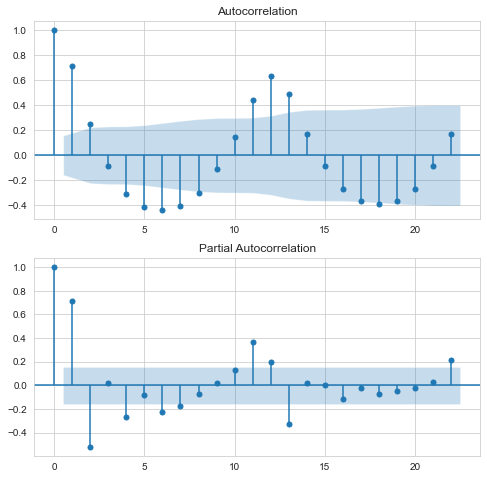

In [24]:
#Gráficos ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(serie_treino, ax = ax1)
plot_pacf(serie_treino, ax = ax2)
plt.show()

**Treinando o modelo**

Para a série  estacionária sem necessidade de diferenciação (d=0), será utilizada a função auto_arima para determinar o melhor modelo que se adequa à série.

p = número de time lags do modelo auto-regressivo (AR)<br>
q = ordem do modelo de média-móvel (MA)<br>
d = grau de diferenciação<br>
P = refere-se ao termo auto-regressivo para a parte sazonal<br>
Q = refere-se ao termo de diferenciação para a parte sazonal<br>
D = refere-se ao termo da média-móvel para a parte sazonal<br>

In [ ]:
#Modelo
modelo = pm.auto_arima(serie_treino['total'], start_p=1, start_q=1,
                      max_p=3, max_q=3, 
                      m=12,              #frequencia 12 meses
                      d=0,           
                      stationary = True, 
                      seasonal=True, #Sazonalidade
                      start_P=0, 
                      D=1, 
                      trace=True, #reporta a lista de modelos ARIMA considerados.
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) 

#Treinando o modelo
modelo.fit(serie_treino['total'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3429.309, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3598.886, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3437.928, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3468.773, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3671.366, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3454.045, Time=0.05 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3406.314, Time=0.57 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3409.702, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=3402.671, Time=0.57 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3401.005, Time=0.44 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3453.534, Time=0.49 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3429.239, Time=0.86 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3402.963, Time=0.50 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=3394.791, Time=0.45 sec
 ARIMA(1,0,2)(1,0,0

In [ ]:
print(modelo.summary())

**Predição e apresentação**

In [ ]:
#Predição
prev_arima = modelo.predict(n_periods=len(serie_teste['total']))
prev_arima = pd.DataFrame(prev_arima, index = serie_teste.index,columns=['Prediction'])
conf_int = modelo.predict(len(serie_teste['total']), return_conf_int=True, alpha = 0.05) #intervalo de confiança

In [ ]:
#Gráfico treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos')
plt.plot(serie_treino['total'], color='green', label = 'Dados de treinamento')
plt.plot(serie_teste['total'], color = 'blue', label = 'Dados de teste')
plt.fill_between(serie_teste.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(prev_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.ylabel('Total de focos')
plt.legend()
plt.show()

In [ ]:
#gráfico com foco em teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos')
plt.plot(serie_teste['total'], color = 'blue', label = 'Dados de teste')
plt.fill_between(serie_teste.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(prev_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.ylabel('Total de focos')
plt.legend()
plt.show()

In [ ]:
#Cálculo do erro
mse = mean_squared_error(serie_teste['total'], prev_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(serie_teste['total'], prev_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(serie_teste['total'], prev_arima['Prediction']))
print('RMSE: '+str(rmse))


In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(modelo.resid())
residuals.plot()

In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())